In [653]:
# import the necessary external modules and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, f1_score,  recall_score
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
import pickle
from sklearn.metrics import silhouette_score

## 1. Data preparation

In [ ]:
# read data
CC_data= pd.read_csv("CC GENERAL.csv")
CC_data.head(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
# avoid warning messages
warnings.filterwarnings("ignore")

## 2. Exploratory Data analysis

In [ ]:
# check information about the dataset
CC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA


 the dataset orginally consists of 8950 entries, it has 18 columns and there are missing values in 2 columns, CREDIT_LIMIT and MINIMUM_PAYMENTS.  and their data types are shown, Originally there are 2 int64 columns (TENURE, CASH_ADVANCE_TRX AND PURCHASES_TRX), there is one column of object type(CUST_ID) and the rest 14 columns are of float 64 
CUST_ID column is only the unique identifier of the entries thus it is of no use in both clustering and prediction thus it makes senses to eliminate the column

In [ ]:
# eliminate CUST_ID column because it does not contribute in clustering and prediction
CC_data.drop(['CUST_ID'], axis=1, inplace=True)

In [ ]:
# check for missing 
CC_data.isnull().sum().sort_values(ascending=False)

MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
BALANCE                               0
CASH_ADVANCE_FREQUENCY                0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
PURCHASES_INSTALLMENTS_FREQUENCY      0
BALANCE_FREQUENCY                     0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_FREQUENCY                   0
CASH_ADVANCE                          0
INSTALLMENTS_PURCHASES                0
ONEOFF_PURCHASES                      0
PURCHASES                             0
TENURE                                0
dtype: int64

The program above shows that there 313 missing values in MINIMUM_PAYMENTS column and 1 missing value in CREDIT_LIMIT column

In [ ]:
# checking for duplicates
if CC_data.duplicated().any()==True:
    print("there are duplicate values in dataset")
else:
    print("there are no duplicates in the dataset")

there are no duplicates in the dataset


In [ ]:
# handle missing values (by median)
CC_data["MINIMUM_PAYMENTS"].fillna(CC_data["MINIMUM_PAYMENTS"].median(), inplace=True)
CC_data["CREDIT_LIMIT"].dropna(inplace=True)
CC_data.dropna(inplace=True)
CC_data.isnull().sum()


BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

we handled missing values in 'MINIMUM PAYMENTS' by filling the missing values by the median of the data in the columns. The reason is that we have a lot of missing values in the column, there were 313 missing values in the column which is about 3.5% percentage of the whole daset, losing 3.5% of the data could read to incorrect decision that is why we did not drop them but instead we used median of data in the column to handle missing value in this column. The reason behind using median, distribution graphs shown below, we can see that the data in Minimum payment column is skewed on right (positively skewed). For randomly missing values in the positively skewed "minimum payments" feature, using the median for imputation is prudent, offering robustness against outliers and preserving the skewed distribution's characteristics.  thus we imputed the missing values in the column by the average of the all other values in the columns.
On another hand we the 1 missing values which was present in CREDIT_LIMIT was handled by dropping the the that entry with the missing values because loosing only one entry in the dataset of 8950 would not lead to any error or bias, we still obtained the correct information about the dataset.

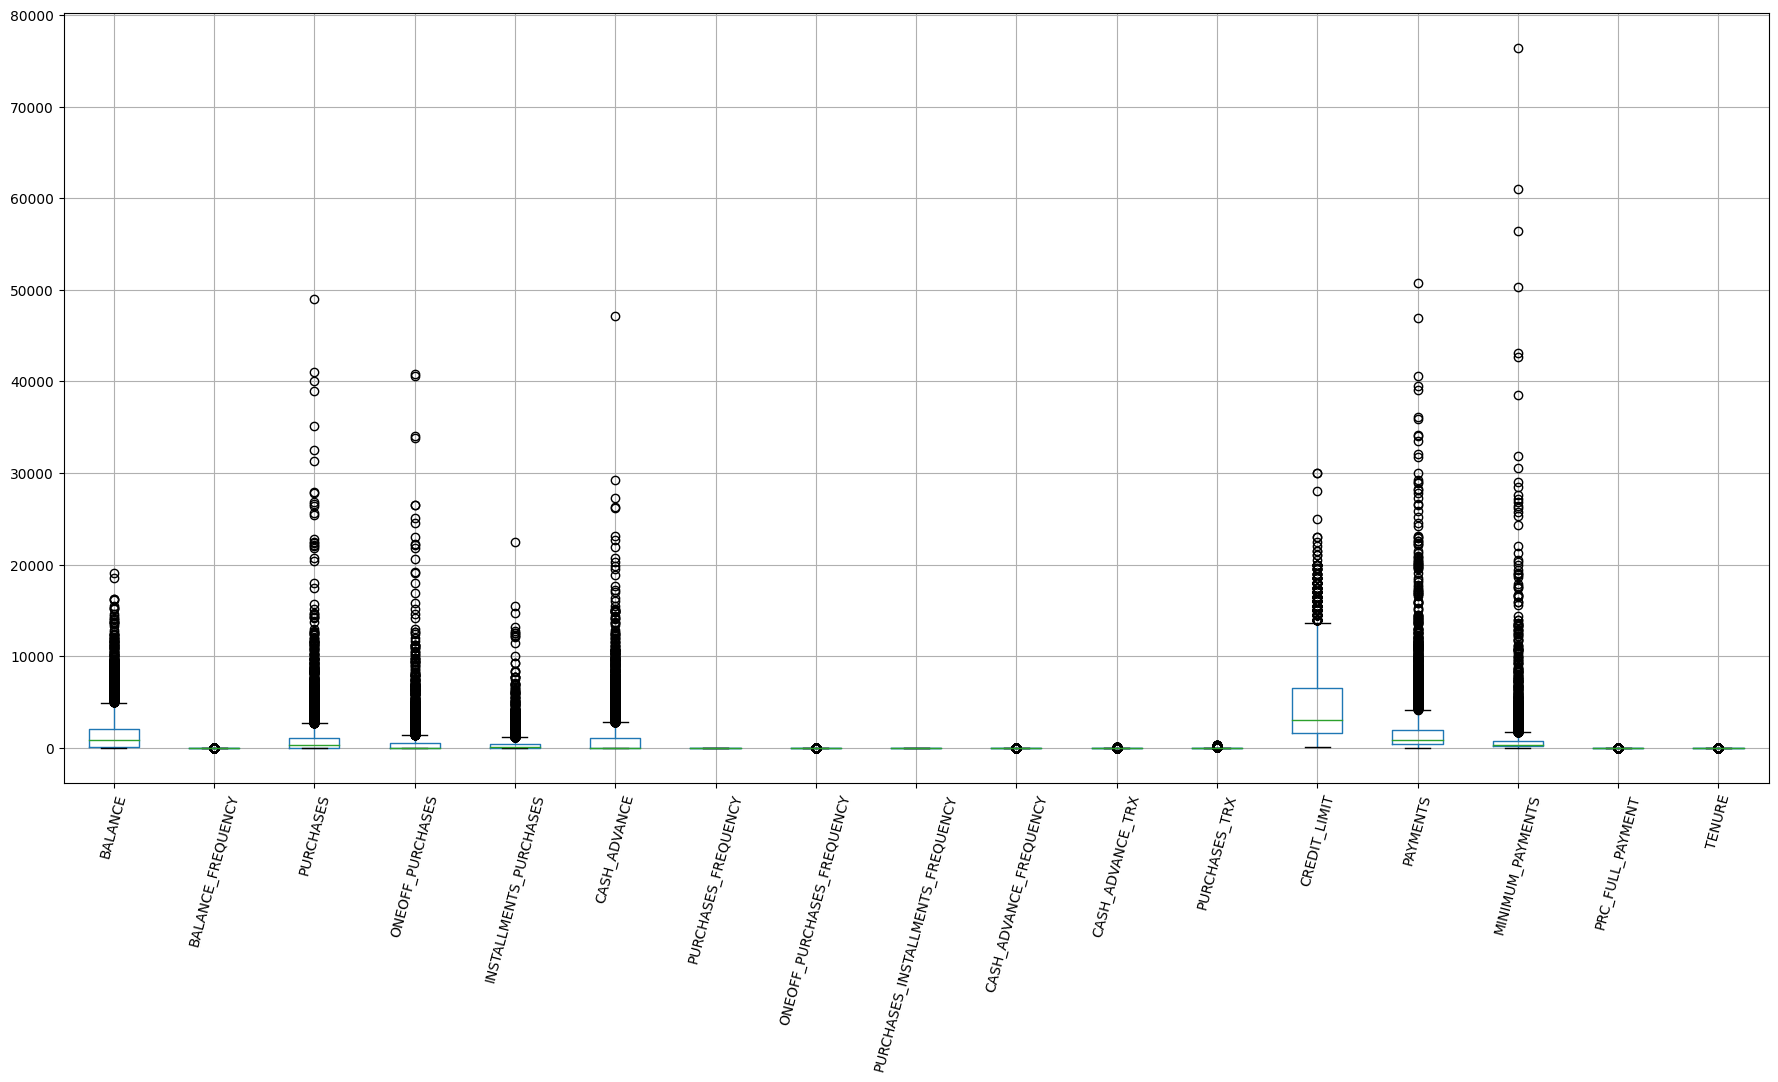

In [ ]:
# checking for outliers
plt.figure(figsize=(22,10))
CC_data.boxplot()
plt.xticks(rotation=75)
plt.show()

The graph above shows that there are a lot of outliers in the dataset let us Interquartile method to check to check for exact number of outliers in the column.

In [ ]:
# Using Interquartile Range (IQR) method to check for outliers in each column
def check_outliers(dataframe, threshold=1.5):
    """
    Detect outliers in each column of the dataframe using the Interquartile Range (IQR) method.

    Parameters:
    - dataframe: pandas DataFrame
    - threshold: Multiplier for IQR to identify outliers (default is 1.5)

    Returns:
    - DataFrame containing columns and the number of outliers in each column.
    """

    outlier_counts = {}

    for column in dataframe.columns:
        # Calculate the first quartile (Q1) and third quartile (Q3)
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)

        # Calculate the IQR
        IQR = Q3 - Q1

        # Define the lower and upper bounds for identifying outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Count the number of outliers in the column
        num_outliers = ((dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)).sum()

        # Add to the dictionary
        outlier_counts[column] = num_outliers

    # Create a DataFrame from the dictionary
    outliers_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outliers Count'])
        
    return outliers_df

# Assuming 'CC_data' is your DataFrame
# Call the function to check for outliers in the dataset
outliers_df = check_outliers(CC_data.iloc[:, 1:])

# Display the DataFrame
display(outliers_df)

,Column,Outliers Count
0,BALANCE_FREQUENCY,1492
1,PURCHASES,808
2,ONEOFF_PURCHASES,1013
3,INSTALLMENTS_PURCHASES,867
4,CASH_ADVANCE,1030
5,PURCHASES_FREQUENCY,0
6,ONEOFF_PURCHASES_FREQUENCY,782
7,PURCHASES_INSTALLMENTS_FREQUENCY,0
8,CASH_ADVANCE_FREQUENCY,525
9,CASH_ADVANCE_TRX,804


## Multicollinearity between variables

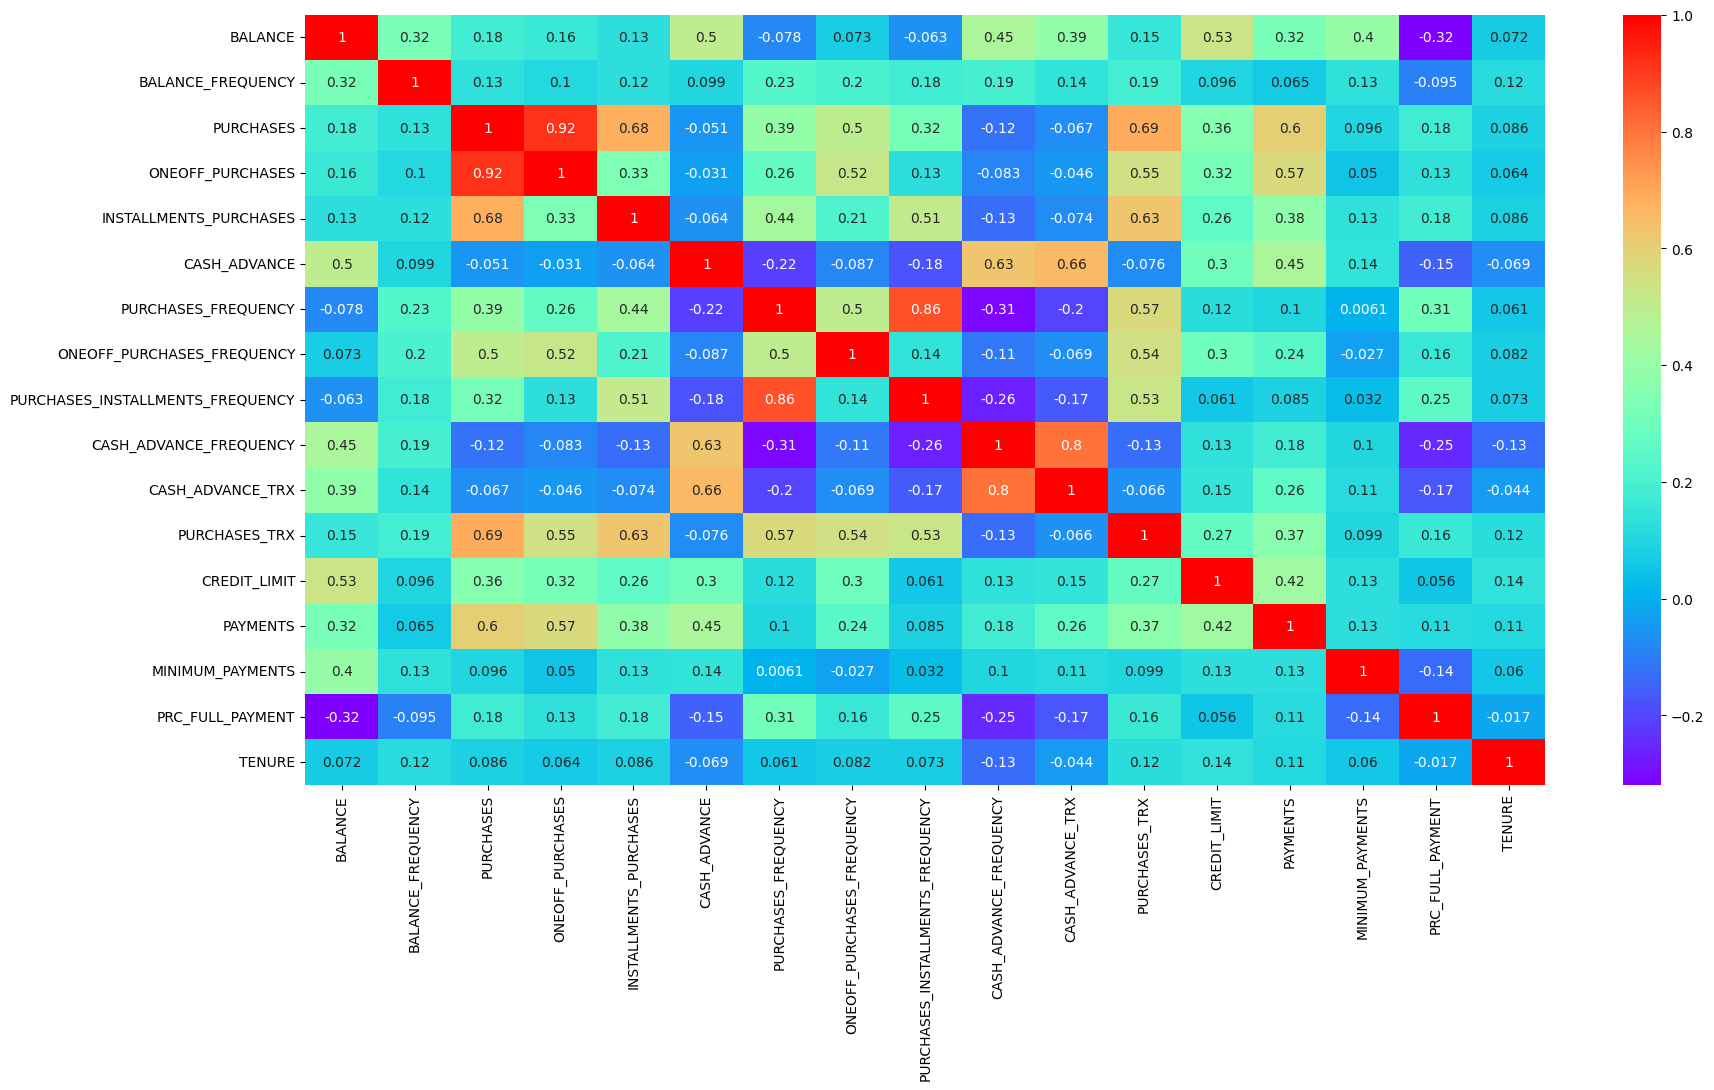

In [ ]:
# find the correlation matrix 
correlation_matrix= CC_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap="rainbow",)
plt.show()

## distribution (skewness) of data in each column

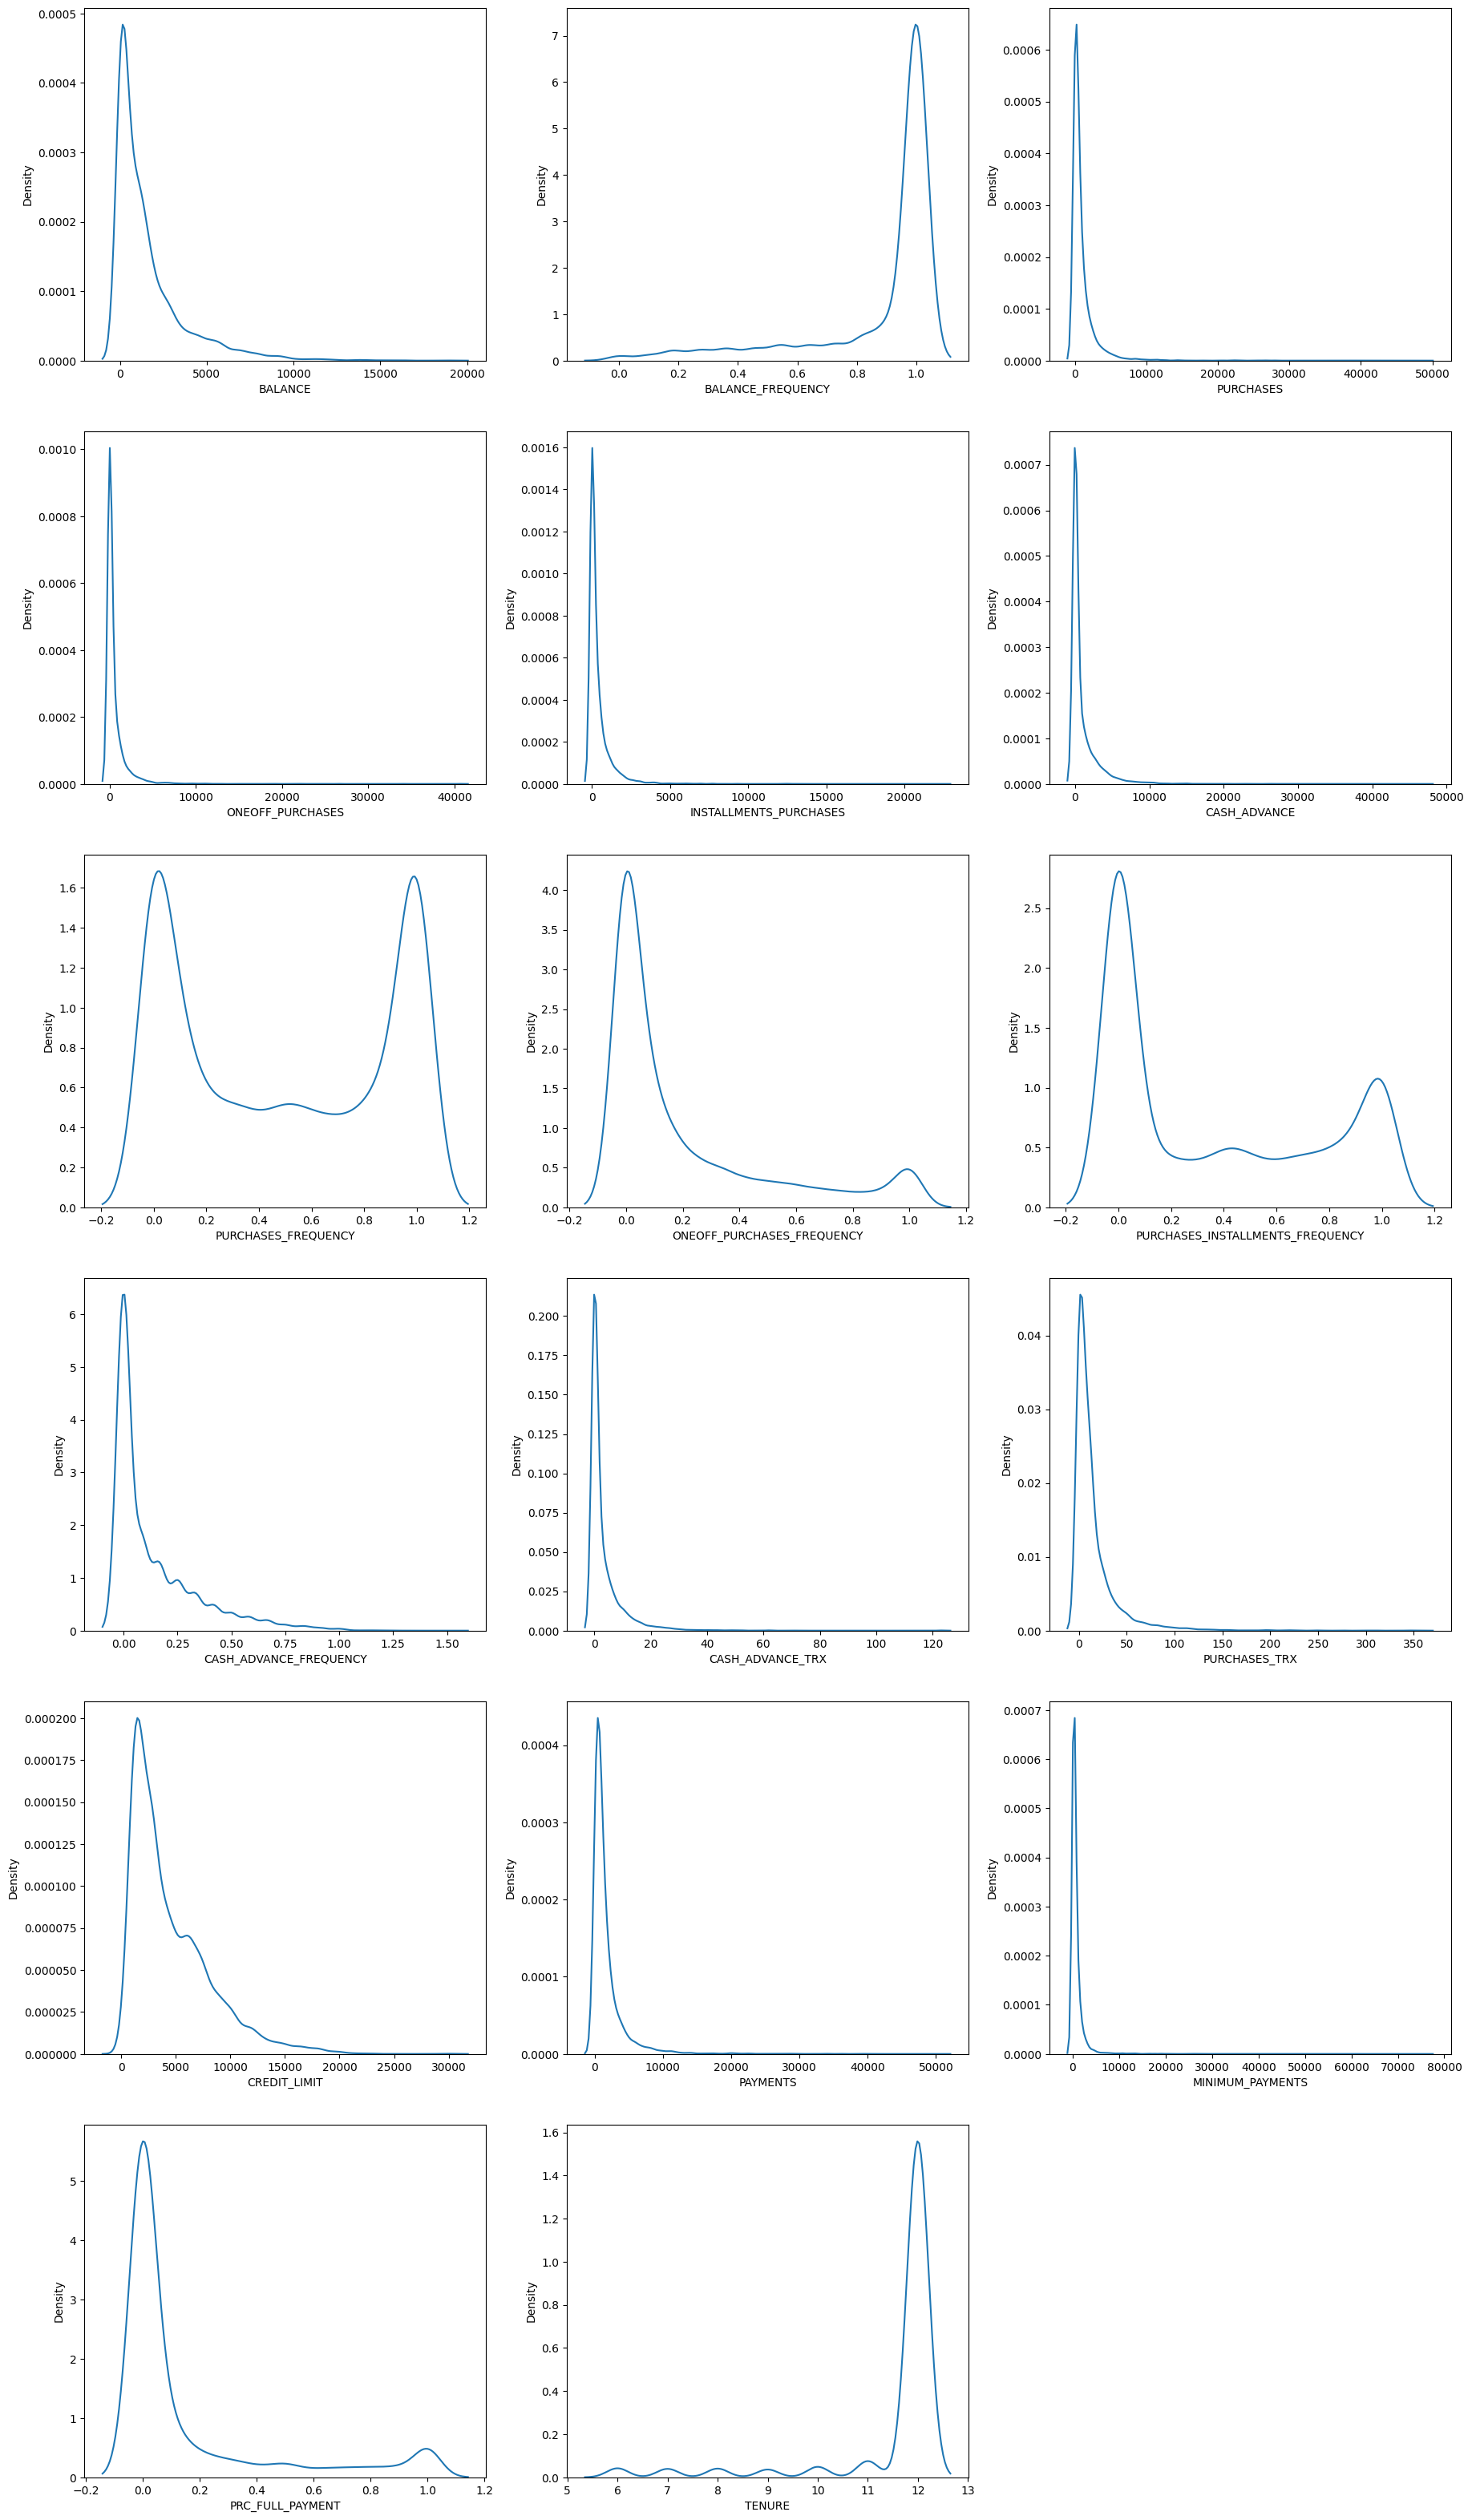

In [ ]:

plt.figure(figsize=(22,40))
for j, column in enumerate( CC_data.columns):
    ax = plt.subplot(6, 3, j+1)
    sns.kdeplot(CC_data[column], ax=ax)
    plt.xlabel(column)
        
plt.show()

The graphs above shows there are alot of skews in the data. There is considerable skewness in the data, and it varies. This is somewhat anticipated in datasets of this nature, given that there will always be a few customers engaging in a high volume of transactions.

The decision to address the skewness in the dataset depends on the nature of our application, particularly for a clustering problem. For instance, if our objective is to perform clustering for anomaly detection, we might choose not to handle the outliers. In such cases, we want the model to identify and group outliers into a cluster. However, for our specific application, which prioritizes effective visualization, I aim to address the skewness as much as possible. This approach is beneficial for enhancing the model's ability to create more meaningful clusters.

since most of variables in the graph above are right skewed it is very useful to use log transformation to handle the skewness. Thus let us the log transformation

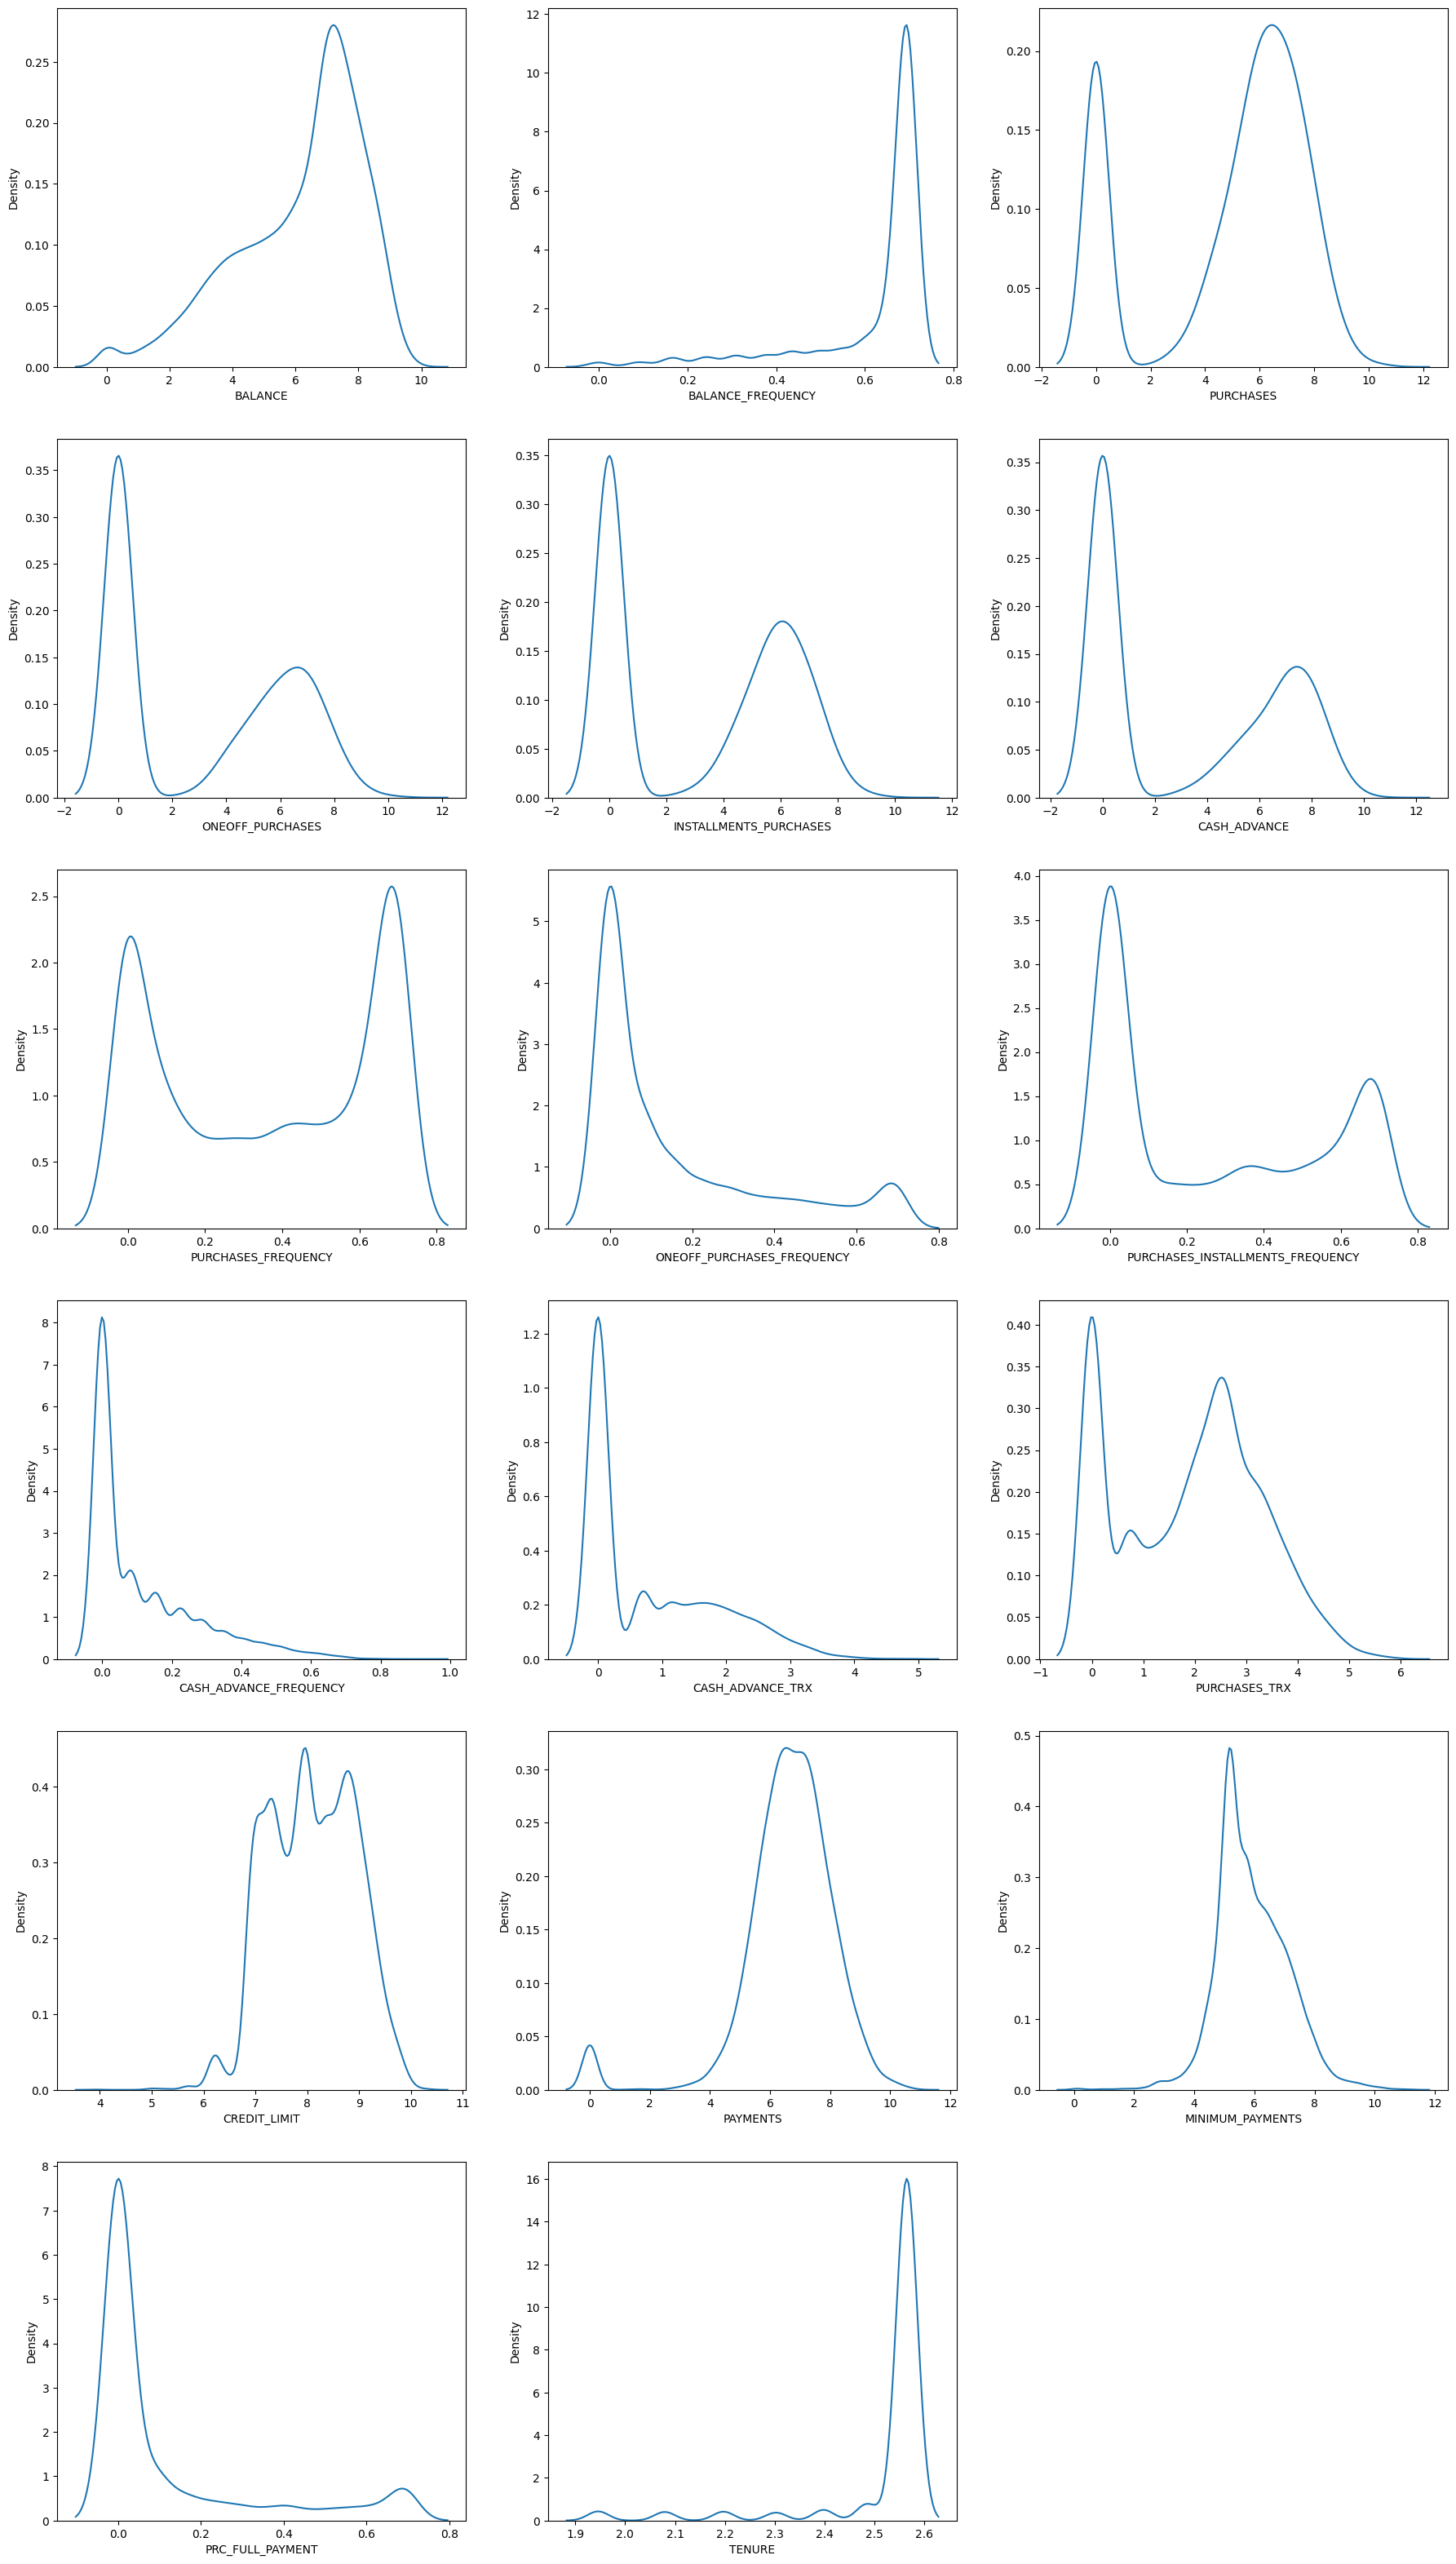

In [ ]:
scaled_data= np.log(1+CC_data)
plt.figure(figsize=(22,40))
for j, column in enumerate( scaled_data.columns):
    ax = plt.subplot(6, 3, j+1)
    sns.kdeplot(scaled_data[column], ax=ax)
    plt.xlabel(column)
        
plt.show()



as it can be observed from the graphs above, after applying logarithmic transformation, the skewness in the data has decreased.

## applying standard scaler

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled = scaler.fit_transform(CC_data)

# If you want to convert the scaled data back to a DataFrame
scaled= pd.DataFrame(CC_data, columns= CC_data.columns)
scaled

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,312.343947,0.000000,6
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


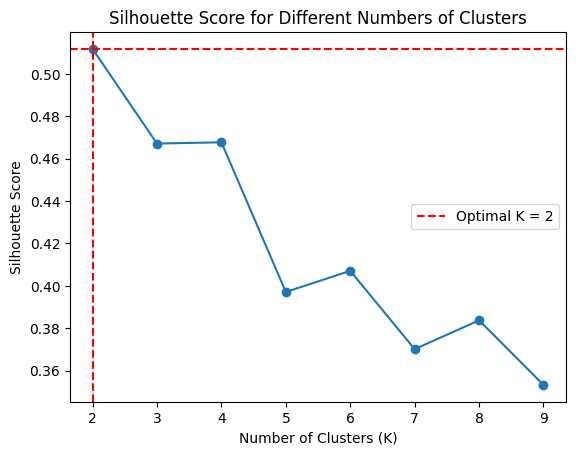

In [658]:
# Assuming scaled_data is your DataFrame
silhouette_scores = {}
# Define a range of cluster numbers to try
k_range = range(2, 10)  # You can adjust the range as needed

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    scaled['Clusters'] = kmeans.fit_predict(scaled)
    
    # Evaluate the clustering performance using silhouette score
    silhouette_avg = silhouette_score(scaled, scaled['Clusters'])
    silhouette_scores[k] = silhouette_avg

# Plot the silhouette scores for different cluster numbers
plt.plot(k_range, silhouette_scores.values(), marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')


# Add a red dashed line at the point with the maximum silhouette score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
optimal_score = silhouette_scores[optimal_k]
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.axhline(optimal_score, color='red', linestyle='--')

plt.legend()
plt.show()


The graph above shows the silhouette score against number of clusters. it shows that the optimal number of clusters (number of clusters for which we obtain highest silhouette score is 2) let us use these number of clusters to perform clustering. 

Silhouette Score: 0.5117381450009677


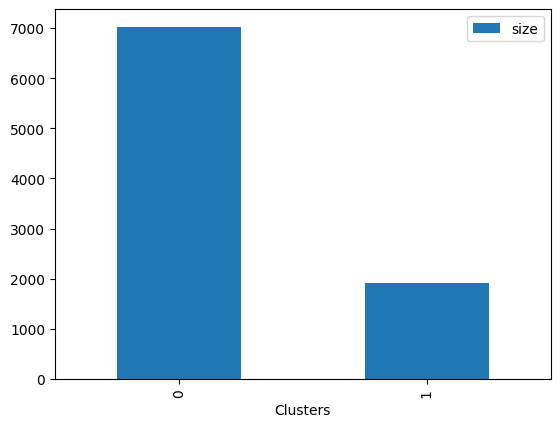

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


# Perform K-Means clustering with K=4
kmeans = KMeans(2,random_state=42)
scaled['Clusters'] = kmeans.fit_predict(scaled)

# Evaluate the clustering performance using silhouette score
silhouette_avg = silhouette_score(scaled, scaled['Clusters'])
print(f"Silhouette Score: {max(silhouette_scores.values())}")

clusters={}
for cluster in scaled['Clusters'].unique():
    nbr_clusters= len(scaled.loc[scaled['Clusters']==cluster])
    clusters[cluster]=nbr_clusters
clusters_df=pd.DataFrame({"Clusters": clusters.keys(), "size": clusters.values()})
clusters_df.set_index("Clusters", inplace=True)
clusters_df.sort_values(by= "size", ascending=False, inplace=True)
clusters_df.plot(kind='bar')
plt.show()

The graph above shows that the data was clustered in 2 clusters, the first cluster, cluster 0 is made  7027 entries, the second cluster, cluster 1 consists of 1922 entries.it shows that cluster 0 has many entries than cluster 1. 

To assess the performance of the Kmeans in clustering we used silhouette score. The use of the silhouette score to evaluate the performance of K-means clustering for credit card customer segmentation is a prudent choice for several reasons. The silhouette score measures how well-defined and separated the clusters are, offering a quantitative assessment of the clustering quality. A high silhouette score indicates that the clusters are distinct and well-separated, signifying a robust segmentation. In the context of credit card customer segmentation, where distinct groups may represent different customer behaviors or profiles, achieving clear and separate clusters is essential for meaningful insights.

In [ ]:
clusters_df

,size
Clusters,
0,7027
1,1922


In [ ]:
#Perform clustering using k-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans.fit_predict(scaled)
scaled_data["Clusters"] = cluster_labels #and assign cluster labels


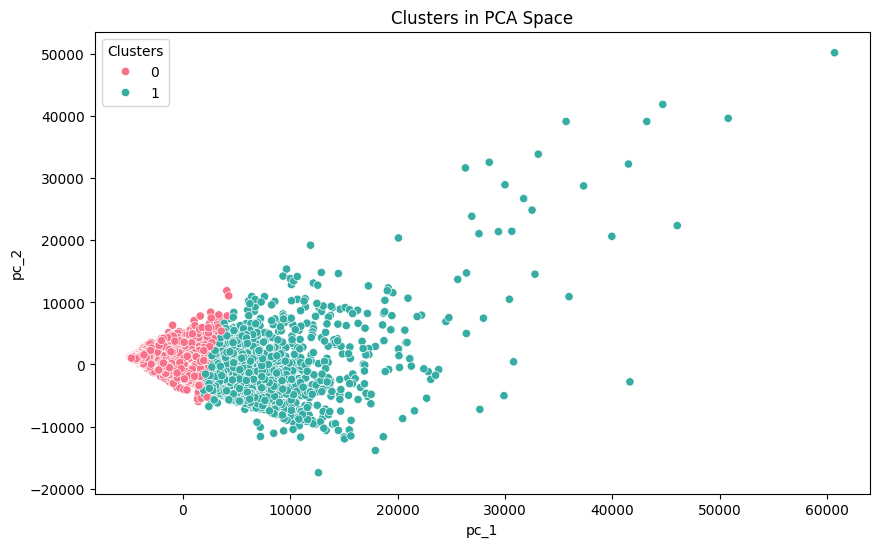

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(scaled)

# Using PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2, whiten=False, random_state=42)
scaled_pca = pca.fit_transform(scaled)
scaled_pca = pd.DataFrame(data=scaled_pca, columns=["pc_1", "pc_2"])
scaled_pca["Clusters"] = cluster_labels

# Define a custom color palette
custom_palette = sns.color_palette("husl", n_colors=len(scaled_pca["Clusters"].unique()))

# Plotting the clusters with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x="pc_1", y="pc_2", hue="Clusters", palette=custom_palette, data=scaled_pca)
plt.title('Clusters in PCA Space')
plt.show()

The graph shows scatter representation in PCA space and the cluster 0 has the lower on first principal component than the cluster 1 which seems to have the higher on first principal component

In [ ]:
# save the scaled dataframe as a labeled data csv file
scaled.to_csv("lniyiteg_cc_labeled.csv")

### Supervised learning

In [ ]:
# read the labeled csv data
labeled_data= pd.read_csv("lniyiteg_cc_labeled.csv")
labeled_data.head()


,Unnamed: 0,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,0
4,4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [ ]:
X= labeled_data.iloc[:, 1:-2]
y=labeled_data["Clusters"]
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Define custom scorers for precision and f1
precision_scorer = make_scorer(precision_score, average='weighted')
f1_scorer = make_scorer(f1_score, average='weighted')

# Use cross-validation to evaluate the model with precision and f1 score
precision_scores = cross_val_score(rf_classifier, X, y, cv=10, scoring=precision_scorer)
f1_scores = cross_val_score(rf_classifier, X, y, cv=10, scoring=f1_scorer)
# Define a custom scorer for recall
recall_scorer = make_scorer(recall_score, average='weighted')

# Use cross-validation to evaluate the model with recall
recall_scores = cross_val_score(rf_classifier, X, y, cv=10, scoring=recall_scorer)

performance_dict= {"performance metrics": ["Recall scores", "Precision Scores", "F1 scores"], "performance before feature selection":[recall_scores.mean(), precision_scores.mean(), f1_scores.mean()] }
performance_df= pd.DataFrame(performance_dict)
performance_df




,performance metrics,performance before feature selection
0,Recall scores,0.987037
1,Precision Scores,0.987136
2,F1 scores,0.987019


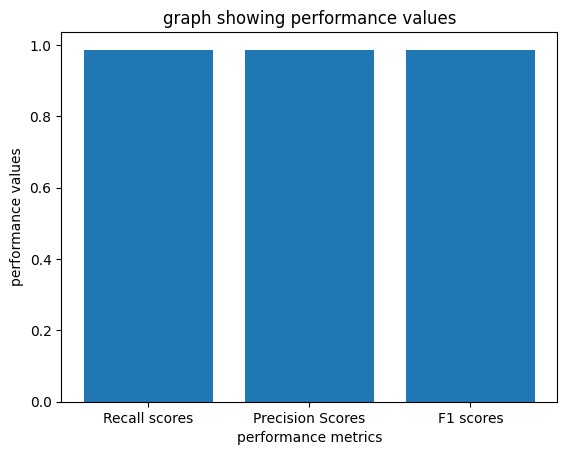

In [ ]:
plt.bar(performance_df["performance metrics"], performance_df["performance before feature selection"])
plt.xlabel("performance metrics")
plt.ylabel("performance values")
plt.title("graph showing performance values")
plt.show()

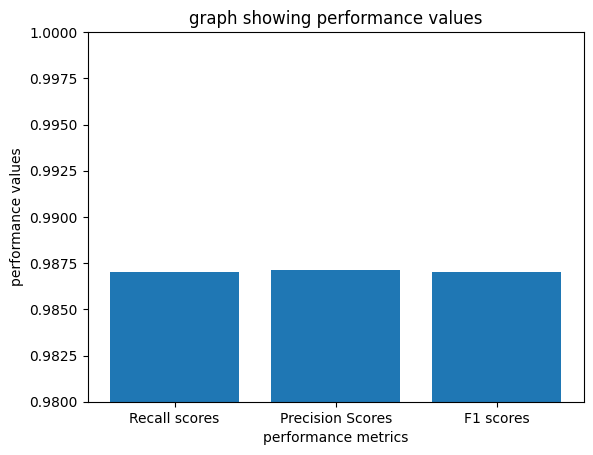

In [ ]:
plt.bar(performance_df["performance metrics"], performance_df["performance before feature selection"])
plt.ylim(0.98,1)
plt.xlabel("performance metrics")
plt.ylabel("performance values")
plt.title("graph showing performance values")
plt.show()

As shown in the graph recall scores and precision scores and f1 scores are close to each other. They are all around 0.987 which make us conclude that there is the model performs better. But precision score is a little a bit higher than F1 score and Recall scores. WE used precision scores, recall scrores and f1 scores for evaluating the performance of the model because there was a significant imbalance in the data. 

### Learning curves

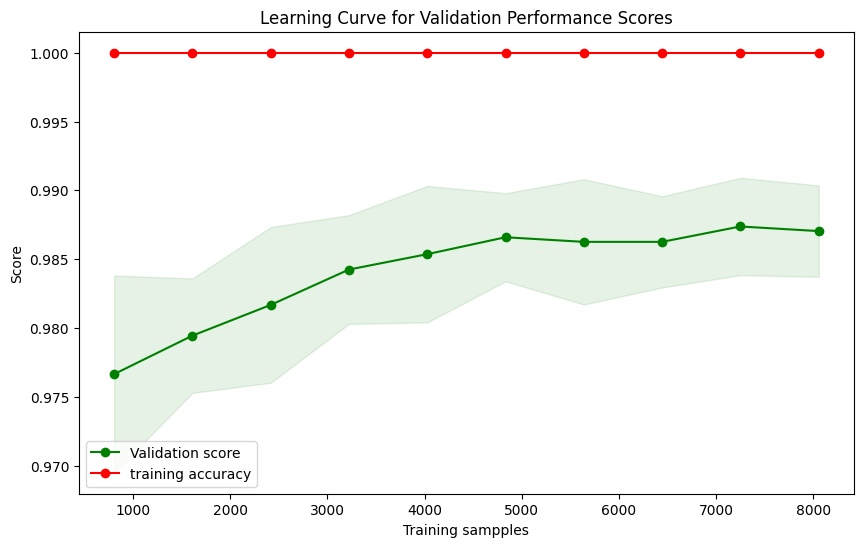

In [ ]:
# Create learning curves using the learning_curve function
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=10, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves for validation performance scores
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.plot(train_sizes, train_scores_mean, 'o-', color= "r", label="training accuracy")
plt.xlabel("Training sampples")
plt.ylabel("Score")
plt.title("Learning Curve for Validation Performance Scores")
plt.legend(loc="best")
plt.show()

The graph above shows the learning curves of random forest with cross validation. it shows that the training accuracy stays at 1 which means that the model learns the training data very well and also the validation score is not that bad is close to one which means that the model is also good at prediction so we can conclude that there was no overfitting since the model was able to learn well training data but also to predict well the unseen data. the distance between the validation score and training accuracy decreased as the model learned more samples that is the perfomance improved time to time as the model was learning more samples.  the model is also not itting because it was able to learn the data well. thus due to above reasons the model was neither overfitting nor underfitting. 

In [ ]:
# Save the model to a file using pickle
with open('model.pkl', 'wb') as model_file:
    pickle.dump(rf_classifier, model_file)
    

## 6)

 1 CREDIT_LIMIT              0.496
 2 BALANCE                   0.134
 3 PAYMENTS                  0.117
 4 CASH_ADVANCE              0.064
 5 MINIMUM_PAYMENTS          0.051
 6 PURCHASES                 0.044
 7 ONEOFF_PURCHASES          0.027
 8 CASH_ADVANCE_TRX          0.012
 9 PURCHASES_TRX             0.012
10 INSTALLMENTS_PURCHASES    0.009
11 CASH_ADVANCE_FREQUENCY    0.008
12 ONEOFF_PURCHASES_FREQUENCY 0.007
13 PRC_FULL_PAYMENT          0.006
14 PURCHASES_FREQUENCY       0.005
15 BALANCE_FREQUENCY         0.004
16 PURCHASES_INSTALLMENTS_FREQUENCY 0.004


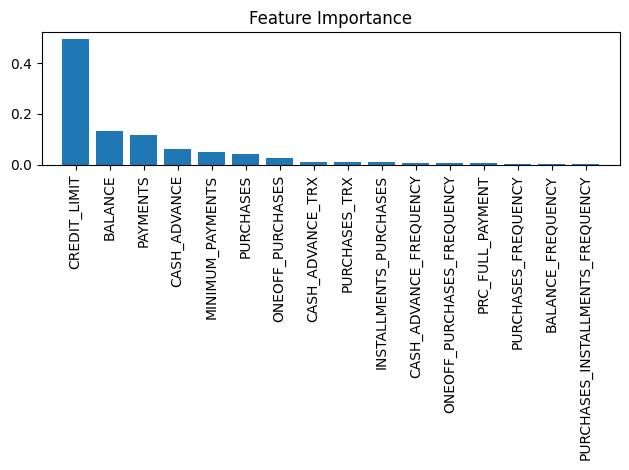

In [ ]:
# Get feature importances
rf_classifier.fit(X,y)
feature_importances = rf_classifier.feature_importances_
feat_labels=labeled_data.columns[1:-1]
indices=np.argsort(feature_importances)[::-1]
for f in range(X.shape[1]):
    print("{:2d} {:25s} {:.3f}".format(f+1, feat_labels[indices[f]], feature_importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1,X.shape[1]])
plt.tight_layout()
plt.show()

The graph above shows the importance of all features some features are of great importance like Credit limit and balance some other features like purchase installment frequency and balance frequency are of less or insignificant importance 

In [ ]:
labeled_data

,Unnamed: 0,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,0
4,4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8944,8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6,0
8945,8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,312.343947,0.000000,6,0
8946,8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6,0
8947,8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6,0


Selected Features:
BALANCE
PURCHASES
ONEOFF_PURCHASES
CASH_ADVANCE
CREDIT_LIMIT
PAYMENTS
MINIMUM_PAYMENTS


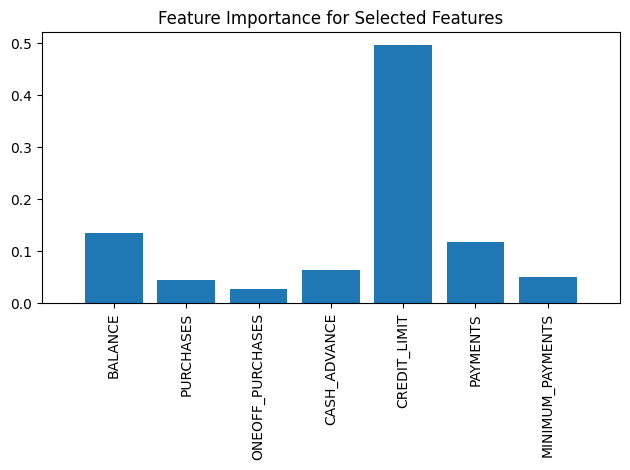

In [ ]:
# set the threshold for feature selection
threshold = 0.02  

# Identify the indices of features with importances above the threshold
selected_feature_indices = np.where(feature_importances > threshold)[0]

# Get the names of the selected features
selected_features = feat_labels[selected_feature_indices]

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)

# Plot feature importances for the selected features
plt.title('Feature Importance for Selected Features')
plt.bar(range(len(selected_feature_indices)), feature_importances[selected_feature_indices], align='center')
plt.xticks(range(len(selected_feature_indices)), selected_features, rotation=90)
plt.xlim([-1, len(selected_feature_indices)])
plt.tight_layout()
plt.show()

After perfoming feature selection only 7 features were selected as there well shown above in the graph with their feature importance. the feature selection technique used is random forest features importance since I was using a random foreste model and due to the fact that this techniques selected features which lead to improvement in the performance while reducing model complexity

In [ ]:
X_selected=labeled_data[selected_features]

y=labeled_data["Clusters"]
# Initialize the Random Forest classifier
sel_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Define custom scorers for precision and f1
sel_precision_scorer = make_scorer(precision_score, average='weighted')
sel_f1_scorer = make_scorer(f1_score, average='weighted')

# Use cross-validation to evaluate the model with precision and f1 score
sel_precision_scores = cross_val_score(sel_rf_classifier, X_selected, y, cv=10, scoring=precision_scorer)
sel_f1_scores = cross_val_score(sel_rf_classifier, X_selected, y, cv=10, scoring=f1_scorer)
# Define a custom scorer for recall
sel_recall_scorer = make_scorer(recall_score, average='weighted')

# Use cross-validation to evaluate the model with recall
sel_recall_scores = cross_val_score(sel_rf_classifier, X_selected, y, cv=10, scoring=recall_scorer)


performance_df["After feature selection"]= [sel_recall_scores.mean(), sel_precision_scores.mean(), sel_f1_scores.mean()]
performance_df
sel_rf_classifier.fit(X_selected,y)
with open('select_model.pkl', 'wb') as model_file:
    pickle.dump(sel_rf_classifier, model_file)



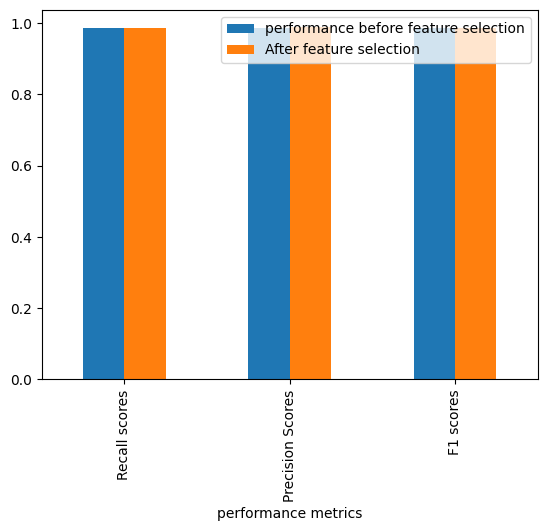

In [ ]:
# compare the performance on the  graph

performance_df.set_index("performance metrics", inplace=True)
performance_df.plot(kind="bar")
plt.show()

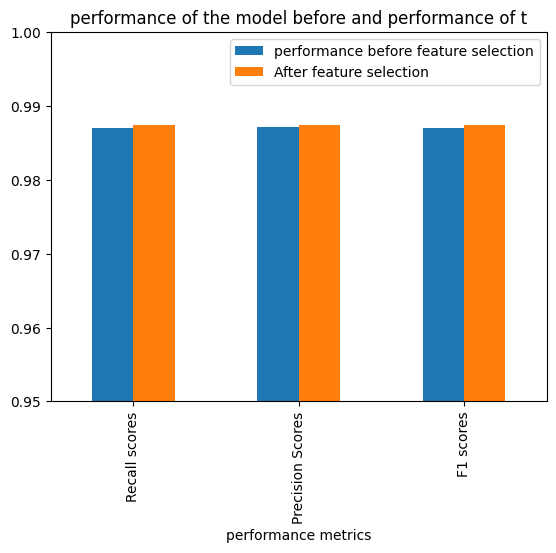

In [ ]:

performance_df.plot(kind="bar", title="performance of the model before and performance of t")
plt.ylim(0.95,1)
plt.show()

By training the same model along side with cross validation as it was done before, it was found that After feature selection the performance of the model has improved a bit. as it can be seen from the graph above. 

## learning curves after feature selection

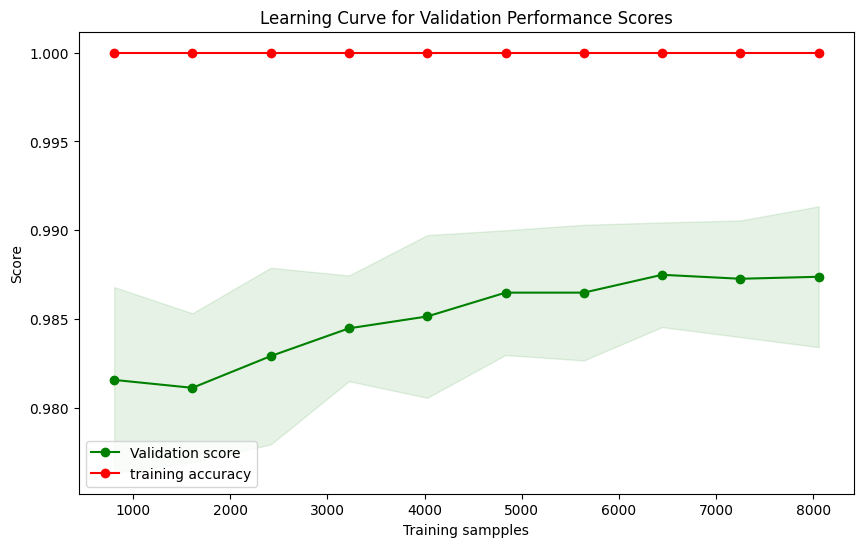

In [ ]:
# Create learning By curves using the learning_curve function
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_selected, y, cv=10, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves for validation performance scores
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.plot(train_sizes, train_scores_mean, 'o-', color= "r", label="training accuracy")
plt.xlabel("Training sampples")
plt.ylabel("Score")
plt.title("Learning Curve for Validation Performance Scores")
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, f1_score, recall_score
import pandas as pd
import pickle

X_selected = labeled_data[selected_features]
y = labeled_data["Clusters"]

benchmark_model=sel_rf_classifier
# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    
}

# Choose appropriate evaluation metrics
scorers = {
    'f1_score': make_scorer(f1_score, average='weighted'),
    'precision_score': make_scorer(precision_score, average='weighted'),
    'recall_score': make_scorer(recall_score, average='weighted')
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(benchmark_model, param_grid, scoring=scorers, cv=5, refit='f1_score')
grid_search.fit(X_selected, y)

# Retrieve the best estimator
best_estimator = grid_search.best_estimator_

# Save the tuned model using pickle
with open('tuned_model.pkl', 'wb') as model_file:
    pickle.dump(best_estimator, model_file)

## 7.b)

The chosen hyperparameters, 'n_estimators' and 'max_depth,' are fundamental for Random Forests. 'n_estimators' defines the number of trees in the ensemble, impacting model generalization and computational efficiency. Values like 50, 100, and 200 are commonly explored. 'max_depth' controls the depth of each tree, influencing model complexity and the risk of overfitting. Choices such as None (unlimited depth), 10, and 20 strike a balance between capturing intricate patterns and preventing overfitting. These hyperparameters collectively address the trade-off between model performance and complexity, providing a focused and effective approach to Random Forest hyperparameter tuning.

# 7.c)

,benchmark model,tuned model
model metrics,,
f1-score,0.986558,0.986891
Precision score,0.986672,0.986991
recall score,0.986591,0.986926


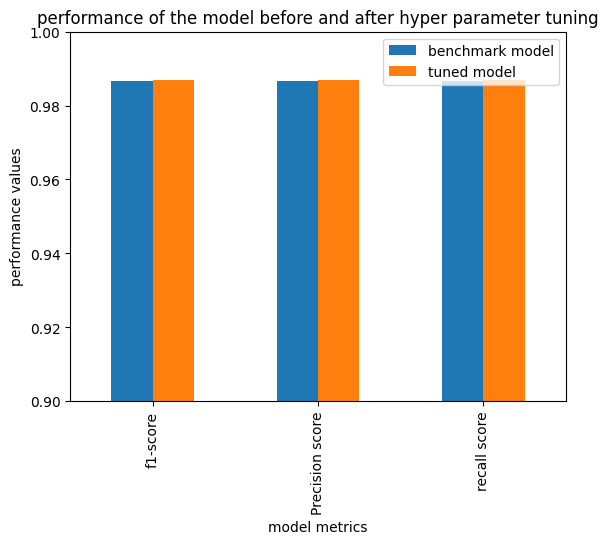

Tuned model is selected as the final benchmark.


In [ ]:
benchmark_f1_scores = cross_val_score(benchmark_model, X_selected, y, cv=5, scoring='f1_weighted')
benchmark_precision_scores = cross_val_score(benchmark_model, X_selected, y, cv=5, scoring='precision_weighted')
benchmark_recall_scores = cross_val_score(benchmark_model, X_selected, y, cv=5, scoring='recall_weighted')

benchmark_f1 = benchmark_f1_scores.mean()
benchmark_precision = benchmark_precision_scores.mean()
benchmark_recall = benchmark_recall_scores.mean()

# Evaluate the tuned model
tuned_f1_scores = cross_val_score(best_estimator, X_selected, y, cv=5, scoring='f1_weighted')
tuned_precision_scores = cross_val_score(best_estimator, X_selected, y, cv=5, scoring='precision_weighted')
tuned_recall_scores = cross_val_score(best_estimator, X_selected, y, cv=5, scoring='recall_weighted')

tuned_f1 = tuned_f1_scores.mean()
tuned_precision = tuned_precision_scores.mean()
tuned_recall = tuned_recall_scores.mean()

performance_comp_dict= {"model metrics": ["f1-score", "Precision score", "recall score"], "benchmark model": \
[benchmark_f1, benchmark_precision, benchmark_recall], "tuned model": [tuned_f1, tuned_precision, tuned_recall] }

performance_comp_df= pd.DataFrame(performance_comp_dict)
performance_comp_df.set_index("model metrics", inplace=True)
display(performance_comp_df)
performance_comp_df.plot(kind="bar")
plt.ylim(0.9,1)
plt.title("performance of the model before and after hyper parameter tuning")
plt.ylabel("performance values")
plt.show()

# Choose the final benchmark model based on performance
if tuned_f1 > benchmark_f1:
    final_benchmark_model = best_estimator.fit(X,y)
    print("Tuned model is selected as the final benchmark.")
else:
    final_benchmark_model = benchmark_model.fit(X,y)
    print("Benchmark model is selected as the final benchmark.")

# Save the final benchmark model
with open('final_benchmark_model.pkl', 'wb') as final_model_file:
    pickle.dump(final_benchmark_model, final_model_file)


The graph and the table above it shows that after hyper parameter tuning the tuned model has a slightly higher performance than the benchmark model. 

### Model deployment

In [662]:
from flask import Flask, render_template, request, flash
import pickle
import numpy as np

app=Flask(__name__) #creates the app to process the user input
#Configure the app
app.logger.setLevel('INFO')
app.secret_key = "cc_prediction"

#Define the functions that represent the actions that occur as the user interacts with the app.
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict',methods=['POST'])
def predict():
    if request.method =='POST':
        
        try:
        
            #Retrieve the form inputs;
            balance=float(request.form['balance'])
            print(balance)
            purchases=float(request.form['purchases'])
            onoff_purchases=float(request.form['onoff_purchases'])
            cash_advance=float(request.form['cash_advance'])
            credit_limit=float(request.form['credit_limit'])
            payments=float(request.form['payments'])
            minimum_payments=float(request.form['minimum_payments'])
        
            prediction="Name"
            color_signal= ("äge")
            #Consolidate the inputs;
            input_args=[balance, purchases,
                    onoff_purchases, cash_advance,
                    credit_limit, payments, 
                    minimum_payments]
            input_arr=np.array(input_args)
            inputs=input_arr.reshape(1,-1) 
            print(inputs)
            #load the saved model
            model = pickle.load(open('select_model.pkl','rb'))
            result=model.predict(inputs)
            if result[0]== 0:
                prediction ='inactive CC_user'
                color_signal='green'
            else:
                prediction ='active CC_user'
                color_signal='red'
                
            #Populate flashed messages
            flash(prediction)
            flash(color_signal)

        except ValueError:
            return "Error: Values not valid."
        
        return render_template('/predict.html',prediction="prediction", color_signal="color_signal")



In [663]:
if __name__=='__main__':
    app.run(host='localhost', port=1887, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:1887
Press CTRL+C to quit
127.0.0.1 - - [17/Dec/2023 09:25:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Dec/2023 09:25:48] "POST /predict HTTP/1.1" 200 -
